This is my first try for the Parkinsons Progression challenge.
I will first check the data for completeness and than do some univariant analysis and bivariant analysis.

# Data overview


### smape calculation
This function calculates the metric used for judging the prediction and its' code was shamelessly stolen from [user /bibanh's script](https://www.kaggle.com/code/bibanh/update-57-4-train-inference-randomforest).

In [1]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

### bulding the environment and loading the data

In [2]:
#%% loading the basic environment
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn #makes matplotlib
from pandas.plotting import scatter_matrix

In [3]:
#%% checking the directories
in_dir = "/kaggle/input/amp-parkinsons-disease-progression-prediction"
in_dir_test = os.path.join(in_dir,  "example_test_files")

In [4]:
#%% loading the train data
train_data_in = [file for file in os.listdir(in_dir) if file.endswith("csv")]
train_data_in

['train_proteins.csv',
 'train_clinical_data.csv',
 'supplemental_clinical_data.csv',
 'train_peptides.csv']

In [5]:
#%% for quick access of all tables
tab_prot, tab_clin, tab_supp, tab_pep = [ pd.read_csv(os.path.join(in_dir,csv)) for csv in train_data_in ]
data_tabs_dic = {
  "proteins" : tab_prot,
  "peptides" : tab_pep,
  "clincal_data": tab_clin,
  "suppl_data": tab_supp 
}

In [6]:
#%% loading the test data
test_data_in = os.listdir(in_dir_test)
tab_sub_test , tab_prot_test, tab_pep_test, tab_test = [ pd.read_csv(os.path.join(in_dir_test,csv)) for csv in test_data_in ]

In [7]:
[tab_prot.columns,
tab_prot_test.columns]

[Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'NPX'], dtype='object'),
 Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'NPX', 'group_key'], dtype='object')]

In [8]:
#%% what does the proteomics data look like
[tab_pep.columns,
tab_pep_test.columns]

[Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'Peptide',
        'PeptideAbundance'],
       dtype='object'),
 Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'Peptide',
        'PeptideAbundance', 'group_key'],
       dtype='object')]

In [9]:
tab_prot_test["visit_month"].value_counts()

0    227
6    226
Name: visit_month, dtype: int64

In [10]:
tab_prot_test["group_key"].value_counts()

0    227
6    226
Name: group_key, dtype: int64

In [11]:
tab_prot_test.tail()

,visit_id,visit_month,patient_id,UniProt,NPX,group_key
448,3342_6,6,3342,Q9UHG2,325226.0,6
449,3342_6,6,3342,Q9UKV8,64411.5,6
450,3342_6,6,3342,Q9UNU6,25117.5,6
451,3342_6,6,3342,Q9Y646,51473.3,6
452,3342_6,6,3342,Q9Y6R7,14624.5,6


In [12]:
#%% this is how we need to submit
tab_sub_test
#patient_id - month - udprs_rating - plus_x_months

,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,0,0
1,3342_0_updrs_1_plus_6_months,0,0
2,3342_0_updrs_1_plus_12_months,0,0
3,3342_0_updrs_1_plus_24_months,0,0
4,3342_0_updrs_2_plus_0_months,0,0
...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6
60,50423_6_updrs_4_plus_0_months,0,6
61,50423_6_updrs_4_plus_6_months,0,6
62,50423_6_updrs_4_plus_12_months,0,6


they only want predictions for 0, 6, 12, and 24 months, but the data has observations for up to several years.

In [13]:
#%% checking column names, dimensions, type of columns
for name, tab in data_tabs_dic.items():
    print("\n\t", name)
    print( tab.info() )
    print( "\n","_"*50 ,"\n")


	 proteins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.9+ MB
None

 __________________________________________________ 


	 peptides
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  objec

In [14]:
#%% distribution of values
for name, tab in data_tabs_dic.items():
    print("\n\t", name)
    print( tab.describe() )
    print( "\n","_"*50 ,"\n")


	 proteins
         visit_month     patient_id           NPX
count  232741.000000  232741.000000  2.327410e+05
mean       26.099205   32593.881873  2.712077e+06
std        22.874719   18608.479506  2.224155e+07
min         0.000000      55.000000  8.460820e+01
25%         6.000000   16566.000000  2.946440e+04
50%        24.000000   29313.000000  1.135560e+05
75%        48.000000   49995.000000  5.638940e+05
max       108.000000   65043.000000  6.138510e+08

 __________________________________________________ 


	 peptides
         visit_month     patient_id  PeptideAbundance
count  981834.000000  981834.000000      9.818340e+05
mean       26.105061   32603.465361      6.428902e+05
std        22.913897   18605.934422      3.377989e+06
min         0.000000      55.000000      1.099850e+01
25%         6.000000   16566.000000      2.817425e+04
50%        24.000000   29313.000000      7.430830e+04
75%        48.000000   49995.000000      2.213388e+05
max       108.000000   65043.000000    

In [15]:
#%% head of the tables
for name, tab in data_tabs_dic.items():
    print("\n\t", name)
    print( tab.head() )
    print( "\n","_"*50 ,"\n")


	 proteins
  visit_id  visit_month  patient_id UniProt       NPX
0     55_0            0          55  O00391   11254.3
1     55_0            0          55  O00533  732430.0
2     55_0            0          55  O00584   39585.8
3     55_0            0          55  O14498   41526.9
4     55_0            0          55  O14773   31238.0

 __________________________________________________ 


	 peptides
  visit_id  visit_month  patient_id UniProt  \
0     55_0            0          55  O00391   
1     55_0            0          55  O00533   
2     55_0            0          55  O00533   
3     55_0            0          55  O00533   
4     55_0            0          55  O00533   

                                  Peptide  PeptideAbundance  
0                           NEQEQPLGQWHLS           11254.3  
1                             GNPEPTFSWTK          102060.0  
2                         IEIPSSVQQVPTIIK          174185.0  
3  KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK           27278.9  
4   

In [16]:
#%% missing values
for name, tab in data_tabs_dic.items():
    print("\n\t", name)
    print( tab.isna().sum(axis=0) )
    print( "\n","_"*50 ,"\n")



	 proteins
visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64

 __________________________________________________ 


	 peptides
visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64

 __________________________________________________ 


	 clincal_data
visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

 __________________________________________________ 


	 suppl_data
visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                 2

## Initial Observations
- There are no missing values in the proteomics data (protein table or peptide table).<br>
- The tables are linked by *patient_id*, *patient_id*, *visit_month* <br>
- The clinical table and the supplemental table are similar. <br>
    - They have the same column names.
    - "updrs" is a measure for severity, higher values indicate diseas progression as explained [here](https://www.parkinsonsdaily.com/unified-parkinsons-disease-rating-scale-updrs/).<br>
    - There are quite a few values missing. We need to see how we deal with those.
- Comment's on the abundance column of peptides / protein tables:<br>
    - The proteomics data has its abundance score column named *NPX*.<br>
    - The peptide table uses *PeptideAbundance*.<br>
    - We have peptide data indicating that LC-MS/MS was used the name of the Protein table would expect a different method: *NPX* is usually associated with immunoassays.

# Proteomics data
## Uinvariate analysis
Let's look at the distribution of values and how many proteins we identified.

In [17]:
#%% how many proteins are there?
[ len(tab_prot["UniProt"].unique()) , len(tab_pep["UniProt"].unique())]


[227, 227]

In [18]:
#%% how many peptides were identified for each protein?
tab_pep["UniProt"].value_counts()

P02787    51916
P02768    40900
P01024    35253
P02751    27370
P02649    23082
          ...  
Q6UX71      661
P01780      654
Q562R1      616
Q99832      606
Q99829      489
Name: UniProt, Length: 227, dtype: int64

I modern LC-MS/MS more proteins are identified. These are too few proteins, this must be assay based data.

In [19]:
# log2 of NPX
tab_prot.insert(value = np.log2(tab_prot["NPX"] ), loc= 4 , column="log2NPX")

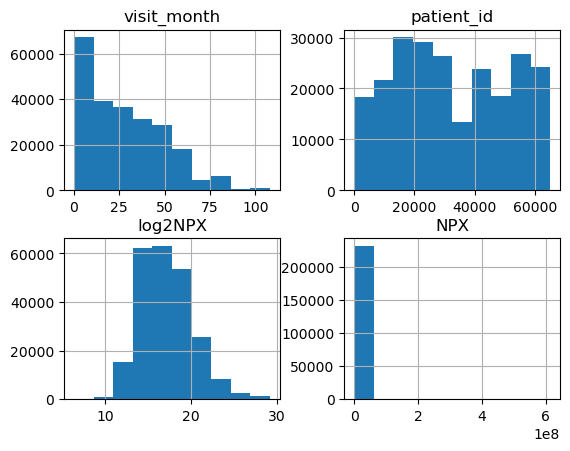

In [20]:
tab_prot.hist()
plt.show()

In [21]:
# log2 of PeptideAbundance
tab_pep.insert(value = np.log2(tab_pep["PeptideAbundance"] ), loc= 4 , column="log2_pep_a")

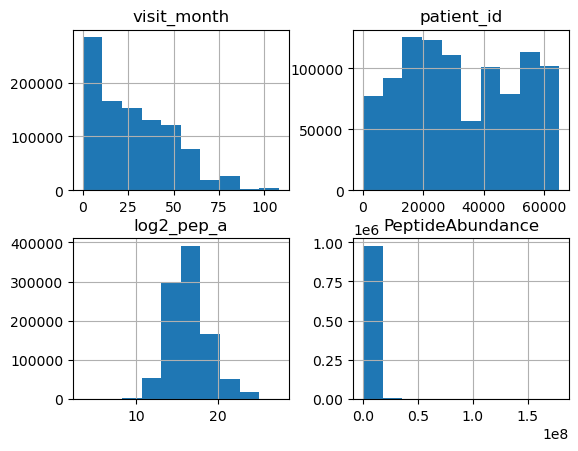

In [22]:
tab_pep.hist()
plt.show()

## Preparing the Proteomics Data

In [23]:
#%% imputation for minimum values of each column with help from ChatGPT
from sklearn.base import BaseEstimator, TransformerMixin

class Proteomics_Imputer(BaseEstimator, TransformerMixin):
    def __init__( self ):
        pass
    
    def fit( self, X, y=None ):
        return self
    
    def transform( self, X ):
        na_columns = X.isna().any()
        col_mins = X.min()
        x_impute_array = np.repeat(col_mins[na_columns], np.sum(na_columns))
        X.loc[:, na_columns] = X.loc[:, na_columns].fillna(x_impute_array)
        print( "using these values for imputation:")
        print( col_mins )
        return X
    


In [24]:
#%% transformer that pivots the table to wide format (with help from chatGPT)
class PivotTableToWider(BaseEstimator, TransformerMixin):
    def __init__(self, index=None, columns=None, values=None, drop_cols=None):
        self.index = index
        self.columns = columns
        self.values = values
        self.drop_cols = drop_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.drop_cols:
            X = X.drop(columns=self.drop_cols)
        df = pd.pivot_table(X, index=self.index, columns=self.columns, values=self.values)
        return df

In [25]:
#my_wider_transform = PivotTableToWider()
#tab_prot_w_ = my_wider_transform.fit( tab_prot_w , columns='UniProt', values='log2NPX',index = "visit_id"  )
#tab_prot_raw = pd.read_csv(os.path.join(in_dir,train_data_in[0]))
my_wider_transform = PivotTableToWider(index='visit_id', columns='UniProt', values='NPX', drop_cols=['patient_id','visit_month'])
tab_prot_w = my_wider_transform.fit_transform(tab_prot)

In [26]:
tab_prot_w

UniProt,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,129048.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,108114.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,163776.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,56725.0,...,557904.0,44556.90,155619.0,14647.90,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,85767.1,...,NaN,47836.70,177619.0,17061.10,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,138910.0,...,NaN,25690.60,NaN,6859.82,19106.7,121161.0,113872.0,14413.9,28225.50,8062.07
942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,100519.0,...,45742.3,33518.60,94049.7,13415.70,21324.7,234094.0,82410.4,19183.7,17804.10,12277.00
942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,99183.5,...,180475.0,29770.60,95949.9,11344.40,23637.6,256654.0,76931.9,19168.2,19215.90,14625.60


In [27]:
# tab_prot_w3 = tab_prot_w.copy()
# my_imputer = Proteomics_Imputer()
# tab_prot_w3 = my_imputer.fit_transform( tab_prot_w3 )
# tab_prot_w3

# clinical data

## Uinvariate analysis


In [28]:
#%% indexing clinical data
tab_clin2 = data_tabs_dic["clincal_data"].copy()
tab_clin2.index= tab_clin2["visit_id"]
tab_clin2.drop(["visit_id"], axis=1, inplace= True)

#imputing the NA with 0
#this needs to be checked with different imputation
tab_clin2 = tab_clin2.fillna( 0 )

In [29]:
#%% checking the raw clinical table
tab_clin2.head()

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
visit_id,,,,,,,
55_0,55,0,10.0,6.0,15.0,0.0,0
55_3,55,3,10.0,7.0,25.0,0.0,0
55_6,55,6,8.0,10.0,34.0,0.0,0
55_9,55,9,8.0,9.0,30.0,0.0,On
55_12,55,12,10.0,10.0,41.0,0.0,On


Imputation is needed

In [30]:
#%% we have proteomics data for each patient
len([x for x in tab_clin["patient_id"].unique() if x in tab_prot["patient_id"].unique()]) / len(tab_clin["patient_id"].unique())

1.0

In [31]:
#%% we have proteomics data for each patient's visit
# patient_visit_overlap = [x for x in tab_clin2.index.unique() if x in tab_prot_w3.index.unique()]
# len(patient_visit_overlap )

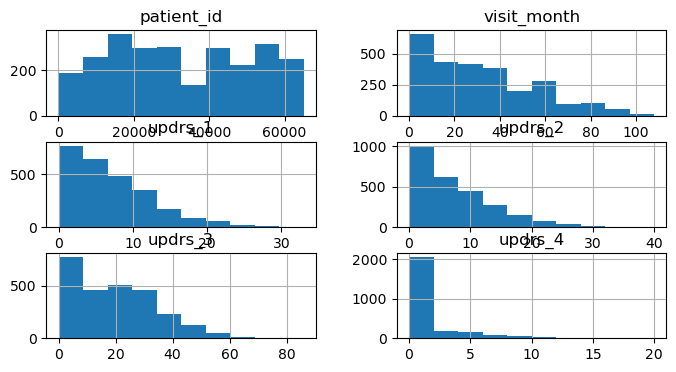

In [32]:
tab_clin2.hist(figsize=(8,4))
plt.show()

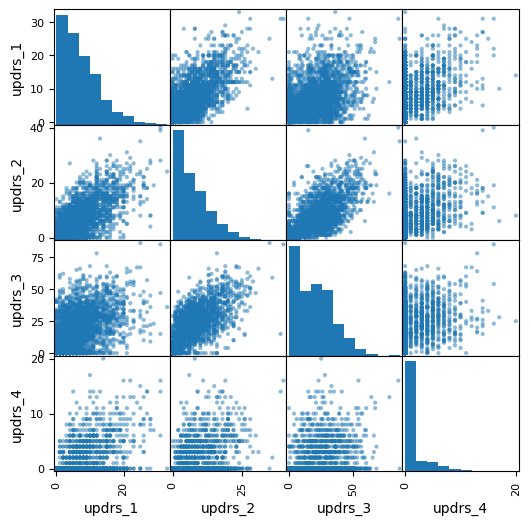

In [33]:
scatter_matrix( tab_clin2[['updrs_1', 'updrs_2','updrs_3', 'updrs_4',]] , figsize=(6,6))
plt.show()

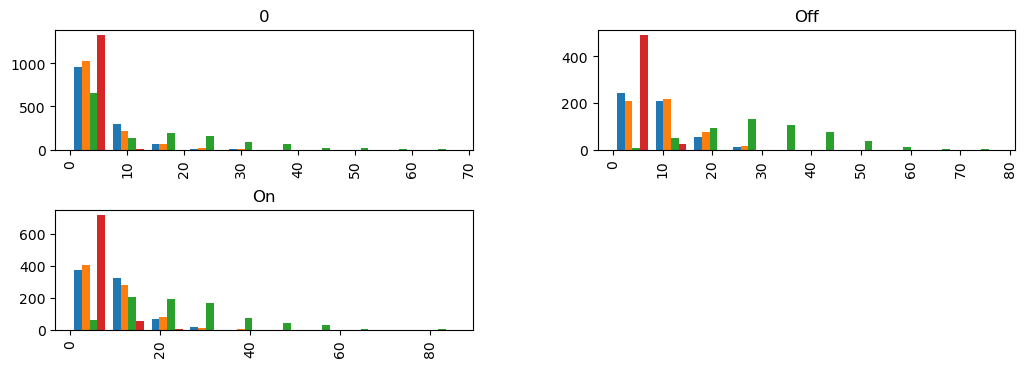

In [34]:
#%% ditribution of updrs values between medicated and non medicated 
tab_clin2[['updrs_1', 'updrs_2','updrs_3', 'updrs_4',"upd23b_clinical_state_on_medication"]].hist( 
    by="upd23b_clinical_state_on_medication",
    figsize=(12,4))
plt.show()

In [35]:
#tab_clin2[['updrs_1', 'updrs_2','updrs_3', 'updrs_4',"visit_id"]].boxplot( by="visit_id",  figsize=(12,4))
#plt.show()

In [36]:
tab_clin2[['updrs_1', 'updrs_2','updrs_3', 'updrs_4',]].corr()

,updrs_1,updrs_2,updrs_3,updrs_4
updrs_1,1.000000,0.662145,0.429453,0.440893
updrs_2,0.662145,1.000000,0.724902,0.414737
updrs_3,0.429453,0.724902,1.000000,0.297336
updrs_4,0.440893,0.414737,0.297336,1.000000


### Wikipedia on MDS-UPDRS

    Part I: Nonmotor experiences of daily living: 13 items. Score range: 0–52,[8] 10 and below is mild, 22 and above is severe.[9]
    Part II: Motor experiences of daily living: 13 items. Score range: 0–52,[8] 12 and below is mild, 30 and above is severe.[9]
    Part III: Motor examination: 18 items. Score range: 0–132,[8] 32 and below is mild, 59 and above is severe.[9]
    Part IV: Motor complications: 6 items. Score range: 0–24,[8] 4 and below is mild, 13 and above is severe.[9]
    
I would like to use this to rate each patient not with numbers but with 0–4 ratings: 0 (normal), 1 (slight), 2 (mild), 3 (moderate), and 4 (severe) to see if we can determine biomarkers based on this.

In [37]:
tab_clin2[['updrs_1', 'updrs_2','updrs_3', 'updrs_4',]]

,updrs_1,updrs_2,updrs_3,updrs_4
visit_id,,,,
55_0,10.0,6.0,15.0,0.0
55_3,10.0,7.0,25.0,0.0
55_6,8.0,10.0,34.0,0.0
55_9,8.0,9.0,30.0,0.0
55_12,10.0,10.0,41.0,0.0
...,...,...,...,...
65043_48,7.0,6.0,13.0,0.0
65043_54,4.0,8.0,11.0,1.0
65043_60,6.0,6.0,16.0,1.0


In [38]:
def map_updrs_1(rating):
    if not isinstance( rating , float) : return("NA" )
    if rating<4 : x= "normal"
    elif rating < 11: x="mild"
    elif rating < 21 : x="moderate"
    else: x="severe"
    return(x)

def map_updrs_2(rating):
    if not isinstance( rating , float) : return("NA" )
    if rating<4 : x= "normal"
    elif rating < 13: x="mild"
    elif rating < 29 : x="moderate"
    else: x="severe"
    return(x)

def map_updrs_3(rating):
    if not isinstance( rating , float) : return("NA" )
    if rating<4 : x= "normal"
    elif rating <33 : x="mild"
    elif rating < 60 : x="moderate"
    else: x="severe"
    return(x)

def map_updrs_4(rating):
    if not isinstance( rating , float) : return("NA" )
    if rating<1 : x= "normal"
    elif rating <4 : x="mild"
    elif rating < 12 : x="moderate"
    else: x="severe"
    return(x)


In [39]:
tab_clin2.insert( value= [ map_updrs_1 (i) for i in tab_clin2["updrs_1"] ],
                 loc=tab_clin2.shape[1],
                 column= "updrs_1_cat" )

tab_clin2.insert( value= [ map_updrs_2 (i) for i in tab_clin2["updrs_2"] ],
                 loc=tab_clin2.shape[1],
                 column= "updrs_2_cat" )

tab_clin2.insert( value= [ map_updrs_3 (i) for i in tab_clin2["updrs_3"] ],
                 loc=tab_clin2.shape[1],
                 column= "updrs_3_cat" )

tab_clin2.insert( value= [ map_updrs_4 (i) for i in tab_clin2["updrs_4"] ],
                 loc=tab_clin2.shape[1],
                 column= "updrs_4_cat" )


In [40]:
tab_clin2

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_1_cat,updrs_2_cat,updrs_3_cat,updrs_4_cat
visit_id,,,,,,,,,,,
55_0,55,0,10.0,6.0,15.0,0.0,0,mild,mild,mild,normal
55_3,55,3,10.0,7.0,25.0,0.0,0,mild,mild,mild,normal
55_6,55,6,8.0,10.0,34.0,0.0,0,mild,mild,moderate,normal
55_9,55,9,8.0,9.0,30.0,0.0,On,mild,mild,mild,normal
55_12,55,12,10.0,10.0,41.0,0.0,On,mild,mild,moderate,normal
...,...,...,...,...,...,...,...,...,...,...,...
65043_48,65043,48,7.0,6.0,13.0,0.0,Off,mild,mild,mild,normal
65043_54,65043,54,4.0,8.0,11.0,1.0,Off,mild,mild,mild,mild
65043_60,65043,60,6.0,6.0,16.0,1.0,Off,mild,mild,mild,mild


Do clustering with Kmeans instead of PCA

# Prediction using Proteomics Data

## 0 months

Let's see how far we come using more or less a default approach. I saw a [notebook](https://www.kaggle.com/code/bibanh/lb-57-2-ensemble-randomforest-svr-linear) that used only data from March (because it makes for a good prediction) and RF, SVM, and  linear regression (lasso). I will do the same for now, because it seemed to work for him.

I will take the protein table as input and use the protein expression to train 4 models, one for each of the updrs_n[1-4]. Then I will see how they perform. 

Most importantly I need a custom transformer that takes the long protein list and transforms it to wide, applies the log2 transformation and then does numerically meaningful imputation.

Then I will train a few models. If I have time I will also do hyperparameter tuning.

I will basically follow the steps laid out in chapter 2 of [homl](https://www.amazon.co.jp/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646).

In [41]:
tab_prot.columns

Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'log2NPX', 'NPX'], dtype='object')

The pipeline works both columns:  
`NPX`  
`log2NPX`  

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


StandardScaler_wrapper = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in tab_prot_w.columns])
    ], remainder='passthrough')

prot_pipeline = Pipeline(steps=[
    ("pivot" ,  PivotTableToWider(index='visit_id', columns='UniProt', values='log2NPX', drop_cols=['patient_id','visit_month'])),
    ("impute" , Proteomics_Imputer()),
    ("z_scale" , StandardScaler_wrapper) #can be removed
    ]
    )

#prot_pipeline = make_pipeline(steps=[(
#    "pivot" ,  PivotTableToWider(index='visit_id', columns='UniProt', values='NPX', drop_cols=['patient_id','visit_month']),
#    "impute" , Proteomics_Imputer(),
#    "z_scale" , StandardScaler_wrapper, #can be removed
#    )]
#    )

In [43]:
prot_process = prot_pipeline
tab_prot_prep_array = prot_process.fit_transform( tab_prot ) ,

tab_prot_prep = pd.DataFrame( np.array( tab_prot_prep_array ).reshape((tab_prot_w.shape)) ,
                             index= tab_prot_w.index,
                             columns=list( tab_prot_w.columns ))

using these values for imputation:
UniProt
O00391     9.771123
O00533    15.865883
O00584     9.207266
O14498    13.126921
O14773    11.456929
            ...    
Q9UHG2    13.726463
Q9UKV8    11.748113
Q9UNU6    11.947863
Q9Y646    10.993292
Q9Y6R7    11.707014
Length: 227, dtype: float64


In [44]:
tab_prot_w

UniProt,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,129048.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,108114.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,163776.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,56725.0,...,557904.0,44556.90,155619.0,14647.90,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,85767.1,...,NaN,47836.70,177619.0,17061.10,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,138910.0,...,NaN,25690.60,NaN,6859.82,19106.7,121161.0,113872.0,14413.9,28225.50,8062.07
942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,100519.0,...,45742.3,33518.60,94049.7,13415.70,21324.7,234094.0,82410.4,19183.7,17804.10,12277.00
942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,99183.5,...,180475.0,29770.60,95949.9,11344.40,23637.6,256654.0,76931.9,19168.2,19215.90,14625.60


In [45]:
tab_prot_prep

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,0.487859,-0.229627,-5.433198,-2.387059,-1.135259,0.251923,-0.378248,-1.401782,-0.160901,0.075345,...,-2.207286,-1.575895,-0.085528,-2.107067,-0.548242,-0.342476,0.465639,0.382798,-3.561217,0.209373
10053_12,0.603083,-0.076759,-5.433198,-2.387059,-2.640450,-2.124005,0.985629,-1.403153,-0.204091,-0.203883,...,-2.207286,-0.971236,-2.037178,-2.107067,-0.172890,-0.420365,0.462699,-1.373293,-0.999183,0.675374
10053_18,0.797550,0.216847,-1.723982,0.047108,-2.640450,0.191008,0.286271,-1.294718,-0.150014,0.451306,...,0.573889,0.450848,0.378035,-2.107067,0.323961,0.355509,0.387238,-0.072489,-3.561217,0.867974
10138_12,0.756825,0.167660,-1.349263,0.296311,0.713312,1.293759,0.619893,0.432032,0.303133,-1.221375,...,1.025302,0.655083,1.326465,0.321471,0.277090,0.208889,0.866379,1.064761,0.412069,-1.201768
10138_24,0.716650,0.271996,-2.409521,-0.810641,1.128264,0.328770,0.567127,0.372983,0.692098,-0.569173,...,-2.207286,0.757400,1.698696,0.633456,-0.368612,-0.357968,0.380053,0.129078,-0.180966,-1.533409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,0.564120,-0.239365,0.099784,-2.387059,0.255597,1.349048,-0.486549,0.202005,0.818404,0.191521,...,-2.207286,-0.138145,-2.037178,-1.230466,-0.873210,-1.180413,0.921686,0.298819,0.876213,-1.119023
942_12,0.241117,-0.438922,-0.313531,-1.178323,0.406276,-0.188399,-0.306852,-0.094194,0.394484,-0.318793,...,-0.977348,0.245006,-0.091146,0.141708,-0.681482,0.254620,0.652059,0.668127,0.098152,-0.468036
942_24,-1.451922,-0.482803,0.010813,-0.067000,0.231632,-0.362114,0.132774,-0.157892,0.084688,-0.339893,...,0.121651,0.074187,-0.034838,-0.201367,-0.501720,0.455093,0.594699,0.667083,0.227001,-0.197080


In [46]:
tab_clin2

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_1_cat,updrs_2_cat,updrs_3_cat,updrs_4_cat
visit_id,,,,,,,,,,,
55_0,55,0,10.0,6.0,15.0,0.0,0,mild,mild,mild,normal
55_3,55,3,10.0,7.0,25.0,0.0,0,mild,mild,mild,normal
55_6,55,6,8.0,10.0,34.0,0.0,0,mild,mild,moderate,normal
55_9,55,9,8.0,9.0,30.0,0.0,On,mild,mild,mild,normal
55_12,55,12,10.0,10.0,41.0,0.0,On,mild,mild,moderate,normal
...,...,...,...,...,...,...,...,...,...,...,...
65043_48,65043,48,7.0,6.0,13.0,0.0,Off,mild,mild,mild,normal
65043_54,65043,54,4.0,8.0,11.0,1.0,Off,mild,mild,mild,mild
65043_60,65043,60,6.0,6.0,16.0,1.0,Off,mild,mild,mild,mild


In [47]:
#%% prepares the protein + updrs table
def prepare_prot_clin_table( updrs_x , tab_prot_in = tab_prot_prep , tab_clin_in = tab_clin2 ):
    tab_prot_ = tab_prot_in.copy()
    tab_clin_ = tab_clin_in.copy()
    visit_ids_complete = list(set(tab_prot_.index) & set(tab_clin_.index) )
    for tab in [ tab_clin_, tab_prot_]:
        drop_rows =[ i for i in tab.index if i not in visit_ids_complete]
        tab.drop(index=drop_rows, axis=0 , inplace=True )
        tab.sort_index(axis=0 , inplace=True)
    # print( tab_clin_.shape, tab_prot_.shape )
    # print( sum( tab_clin_.index == tab_prot_.index) )
    tab_clin_.index = tab_clin_.index
    drop_cols = [col for col in tab_clin_.columns if col != updrs_x ] #seperately training the model for each udprs e.g. updrs_1 to updrs_4
    tab_clin_.drop( drop_cols, axis=1, inplace= True)
    tab_prot_.insert(value = tab_clin_[updrs_x],
                         loc= tab_prot_.shape[1] , column= updrs_x)
    return( tab_prot_ )

# example:
# prepare_prot_clin_table( "updrs_2" )


In [48]:
#%% splitting in training and test set
from sklearn.model_selection import train_test_split

tab_prep_1 = prepare_prot_clin_table( "updrs_1" )

tab_train, tab_test = train_test_split( tab_prep_1, 
                                       train_size =0.8,
                                       shuffle =True,
                                       random_state =42 )


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [50]:
#%% training random forest
def run_rf(updrs_x , m_d , n_e , val_cv = 5):
    
    tab_prep_x = prepare_prot_clin_table( updrs_x )

    tab_train, tab_test = train_test_split( tab_prep_x, 
                                       train_size = 0.8,
                                       shuffle =    True,
                                       random_state=42 )
    #print( tab_train.columns)
    print("prepared the table")
    
    rf = RandomForestRegressor(max_depth=m_d, n_estimators=n_e, random_state= 42 )
    rf_train = rf.fit(tab_train.drop(updrs_x , axis=1),
                  tab_train[[ updrs_x ]].values.ravel())
    rf_out = rf_train.predict( tab_train.drop(updrs_x,axis=1))
    print("finished training, start validation")
    
    # cross validation
    rf_rmses = cross_val_score( rf_train, 
                            tab_train.drop(updrs_x,axis=1),
                            tab_train[[updrs_x ]].values.ravel(),
                           cv= val_cv ,
                           scoring="neg_root_mean_squared_error"
                          )
    print("checking predictions")
    tab_test_pred = rf_train.predict( tab_test.drop(updrs_x , axis=1))
    mse_train = mean_squared_error(tab_train[[ updrs_x ]].values.ravel(), rf_out)
    mse_test =  mean_squared_error(tab_test[[updrs_x ]].values.ravel(), tab_test_pred)
    mae_train = mean_absolute_error(tab_train[[ updrs_x ]].values.ravel(), rf_out)
    mae_test =  mean_absolute_error(tab_test[[updrs_x ]].values.ravel(), tab_test_pred)
    data_ = { "MSE" : [mse_train , mse_test] , "MAE" : [mae_train , mae_test] }
    print( pd.DataFrame(data_ , index=['train', 'test'] , columns= ["MSE","MAE"]) )

    #print( "train set:\t", mean_squared_error(tab_train[[ updrs_x ]].values.ravel(), rf_out) )
    #print( "eval set:\t",  mean_squared_error(tab_test[[updrs_x ]].values.ravel(), tab_test_pred))
    
    print("saving the data")
    return([ rf_out, rf_rmses ])

In [51]:
#%% training linear regression
def run_lasso(updrs_x , lasso_alpha= 0.1 ,max_iter_ =5001 , val_cv=5 ):
    
    tab_prep_x = prepare_prot_clin_table( updrs_x )

    tab_train, tab_test = train_test_split( tab_prep_x, 
                                       train_size = 0.8,
                                       shuffle =    True,
                                       random_state=42 )
    #print( tab_train.columns)
    print("prepared the table")
    
    lr_lasso = Lasso( alpha=lasso_alpha , max_iter=max_iter_ )
    lr_lasso_train = lr_lasso.fit(tab_train.drop(updrs_x , axis=1),
                  tab_train[[ updrs_x ]].values.ravel())
    lr_lasso_out = lr_lasso_train.predict( tab_train.drop(updrs_x,axis=1))
    print("finished training, start validation")
    
    # cross validation
    lr_lasso_rmses = cross_val_score( lr_lasso_train, 
                            tab_train.drop(updrs_x,axis=1),
                            tab_train[[updrs_x ]].values.ravel(),
                           cv= val_cv ,
                           scoring="neg_root_mean_squared_error"
                          )
    print("checking predictions")
    tab_test_pred = lr_lasso.predict( tab_test.drop(updrs_x , axis=1))
    mse_train = mean_squared_error(tab_train[[ updrs_x ]].values.ravel(), lr_lasso_out)
    mse_test =  mean_squared_error(tab_test[[updrs_x ]].values.ravel(), tab_test_pred)
    mae_train = mean_absolute_error(tab_train[[ updrs_x ]].values.ravel(), lr_lasso_out)
    mae_test =  mean_absolute_error(tab_test[[updrs_x ]].values.ravel(), tab_test_pred)
    data_ = { "MSE" : [mse_train , mse_test] , "MAE" : [mae_train , mae_test] }
    print( pd.DataFrame(data_ , index=['train', 'test'] , columns= ["MSE","MAE"]) )
    
    print("saving the data")
    return([ lr_lasso_out, lr_lasso_rmses ])

In [52]:
#%% training linear regression - lasso
def run_lr(updrs_x , val_cv=5 ):
    
    tab_prep_x = prepare_prot_clin_table( updrs_x )

    tab_train, tab_test = train_test_split( tab_prep_x, 
                                       train_size = 0.8,
                                       shuffle =    True,
                                       random_state=42 )
    #print( tab_train.columns)
    print("prepared the table")
    
    lr = LinearRegression( fit_intercept  =True  )
    lr_train = lr.fit(tab_train.drop(updrs_x , axis=1),
                  tab_train[[ updrs_x ]].values.ravel())
    lr_out = lr_train.predict( tab_train.drop(updrs_x,axis=1))
    print("finished training, start validation")
    
    # cross validation
    lr_rmses = cross_val_score( lr_train, 
                            tab_train.drop(updrs_x,axis=1),
                            tab_train[[updrs_x ]].values.ravel(),
                           cv= val_cv ,
                           scoring="neg_root_mean_squared_error"
                          )
    print("checking predictions")
    tab_test_pred = lr_train.predict( tab_test.drop(updrs_x , axis=1))
    mse_train = mean_squared_error(tab_train[[ updrs_x ]].values.ravel(), lr_out)
    mse_test =  mean_squared_error(tab_test[[updrs_x ]].values.ravel(), tab_test_pred)
    mae_train = mean_absolute_error(tab_train[[ updrs_x ]].values.ravel(), lr_out)
    mae_test =  mean_absolute_error(tab_test[[updrs_x ]].values.ravel(), tab_test_pred)
    data_ = { "MSE" : [mse_train , mse_test] , "MAE" : [mae_train , mae_test] }
    print( pd.DataFrame(data_ , index=['train', 'test'] , columns= ["MSE","MAE"]) )
    
    print("saving the data")
    return([ lr_out, lr_rmses ])

In [53]:
"""
lr_models_validation = {}
for updrs_x in ['updrs_1', 'updrs_2','updrs_3', 'updrs_4',] :
    print( "_"*20 , "\n", updrs_x)
    lr_hyper = [10]
    lr_models_validation[ updrs_x ] = [ run_lr(updrs_x= updrs_x,
                                             val_cv = lr_hyper[0] )]
    lr_models_validation[ updrs_x ].append( lr_hyper )

for updrs_x in ['updrs_1', 'updrs_2','updrs_3', 'updrs_4',] :
    print( pd.Series( lr_models_validation[ updrs_x ][0][1] ).mean() )
"""

'\nlr_models_validation = {}\nfor updrs_x in [\'updrs_1\', \'updrs_2\',\'updrs_3\', \'updrs_4\',] :\n    print( "_"*20 , "\n", updrs_x)\n    lr_hyper = [10]\n    lr_models_validation[ updrs_x ] = [ run_lr(updrs_x= updrs_x,\n                                             val_cv = lr_hyper[0] )]\n    lr_models_validation[ updrs_x ].append( lr_hyper )\n\nfor updrs_x in [\'updrs_1\', \'updrs_2\',\'updrs_3\', \'updrs_4\',] :\n    print( pd.Series( lr_models_validation[ updrs_x ][0][1] ).mean() )\n'

In [54]:
"""
rf_models_validation = {}
for updrs_x in ['updrs_1', 'updrs_2','updrs_3', 'updrs_4',] :
    print( "_"*20 , "\n", updrs_x)
    rf_hyper = [2 , 50, 10]
    rf_models_validation[ updrs_x ] = [ run_rf(updrs_x= updrs_x,
                                             m_d=     rf_hyper[0] ,
                                             n_e=     rf_hyper[1] ,
                                             val_cv = rf_hyper[2] )]
    rf_models_validation[ updrs_x ].append( rf_hyper )
    
for updrs_x in ['updrs_1', 'updrs_2','updrs_3', 'updrs_4',] :
    print( pd.Series( rf_models_validation[ updrs_x ][0][1] ).mean() )
"""

'\nrf_models_validation = {}\nfor updrs_x in [\'updrs_1\', \'updrs_2\',\'updrs_3\', \'updrs_4\',] :\n    print( "_"*20 , "\n", updrs_x)\n    rf_hyper = [2 , 50, 10]\n    rf_models_validation[ updrs_x ] = [ run_rf(updrs_x= updrs_x,\n                                             m_d=     rf_hyper[0] ,\n                                             n_e=     rf_hyper[1] ,\n                                             val_cv = rf_hyper[2] )]\n    rf_models_validation[ updrs_x ].append( rf_hyper )\n    \nfor updrs_x in [\'updrs_1\', \'updrs_2\',\'updrs_3\', \'updrs_4\',] :\n    print( pd.Series( rf_models_validation[ updrs_x ][0][1] ).mean() )\n'

In [55]:
"""
lr_lasso_models_validation = {}
for updrs_x in ['updrs_1', 'updrs_2','updrs_3', 'updrs_4',] :
    print( "_"*20 , "\n", updrs_x)
    lasso_hyper = [0.1 , 25000 , 10]
    lr_lasso_models_validation[ updrs_x ] = [ run_lasso(updrs_x= updrs_x,
                                             lasso_alpha = lasso_hyper[0] ,
                                             max_iter_ =lasso_hyper[1], 
                                             val_cv = lasso_hyper[2] )]
    lr_lasso_models_validation[ updrs_x ].append( lasso_hyper )

for updrs_x in ['updrs_1', 'updrs_2','updrs_3', 'updrs_4',] :
    print( pd.Series( lr_lasso_models_validation[ updrs_x ][0][1] ).mean() )
"""

'\nlr_lasso_models_validation = {}\nfor updrs_x in [\'updrs_1\', \'updrs_2\',\'updrs_3\', \'updrs_4\',] :\n    print( "_"*20 , "\n", updrs_x)\n    lasso_hyper = [0.1 , 25000 , 10]\n    lr_lasso_models_validation[ updrs_x ] = [ run_lasso(updrs_x= updrs_x,\n                                             lasso_alpha = lasso_hyper[0] ,\n                                             max_iter_ =lasso_hyper[1], \n                                             val_cv = lasso_hyper[2] )]\n    lr_lasso_models_validation[ updrs_x ].append( lasso_hyper )\n\nfor updrs_x in [\'updrs_1\', \'updrs_2\',\'updrs_3\', \'updrs_4\',] :\n    print( pd.Series( lr_lasso_models_validation[ updrs_x ][0][1] ).mean() )\n'

### Conclusion

The random forest model was overfitted in the previous version.  
linear regression, rf, lasso perform similar and poorly.  
- the cross validation shows that they perform similarly poorly  
- using the MSE and the MAR shows that rf is underfitted and the linear models are overfitted  
    - the rf model may have the most potentail  

The StandardScaling does not improve the outcome.  
Whether NPX or log2NPX are used does not matter either.  
Imputation by minimum values is slightly better than median.  
The current imputation of missing USDPR values is just NA <- 0 which is very bad. I need to check:  
- Kmeans imputation  
- mean imoutation  
- removing NAs patients completely  

## 3, 6, 12 months Predictions

My plan is to:  
1) calculate the time difference of each visit  
2) calculate the difference in Protein abundance  
3) use the fitting time points to build models  

The time points when patients visited vary a lot:

In [56]:
#%% when did the patience get checked
patient_visit_examples = []
for id_ in set( tab_prot["patient_id"] ):
    visit_months_ = sorted( set([x for x in tab_prot[ tab_prot["patient_id"] == id_ ]["visit_month"]] ) )
    patient_visit_examples.append( visit_months_ )

print( patient_visit_examples[0:3] )
print( len( patient_visit_examples) )

[[0, 12, 24, 36, 48, 60], [0, 6, 12], [0, 6, 12, 24]]
248


In [57]:
set( tab_prot["patient_id"] )

{55,
 942,
 1517,
 1923,
 2660,
 3636,
 3863,
 4161,
 4172,
 4923,
 5027,
 5036,
 5178,
 5645,
 5742,
 6054,
 6211,
 6420,
 7051,
 7117,
 7151,
 7265,
 7508,
 7568,
 7832,
 7886,
 8344,
 8699,
 10053,
 10138,
 10174,
 10541,
 10715,
 10718,
 11459,
 11686,
 11928,
 12516,
 12636,
 12703,
 12755,
 12931,
 13360,
 13368,
 13618,
 13804,
 13852,
 13968,
 14035,
 14124,
 14242,
 14270,
 14344,
 14450,
 14811,
 15009,
 15245,
 15504,
 15590,
 16238,
 16347,
 16566,
 16574,
 16778,
 16931,
 17154,
 17201,
 17414,
 17727,
 18183,
 18204,
 18553,
 18560,
 19088,
 20212,
 20216,
 20352,
 20404,
 20460,
 20581,
 20664,
 20707,
 20791,
 20792,
 21126,
 21537,
 21729,
 22126,
 22623,
 23175,
 23192,
 23244,
 23391,
 23636,
 24278,
 24690,
 24818,
 24820,
 24911,
 25562,
 25739,
 25750,
 25827,
 25911,
 26005,
 26104,
 26210,
 26809,
 27079,
 27300,
 27464,
 27468,
 27607,
 27715,
 27872,
 27893,
 27971,
 27987,
 28327,
 28342,
 28818,
 29313,
 29417,
 30119,
 30155,
 30416,
 30894,
 30951,
 31121,

In [58]:
#%% how to calculat the difference between visits
def month_diff_calc( visit_months ):
    #visit_months = [0, 12, 24, 36, 48, 60]
    month_diff = []
    for i in range(len(visit_months)):
        for j in range(i+1, len(visit_months)):
            delta = (visit_months[j] - visit_months[i] )
            month_diff.append(delta)
    return(month_diff) 

In [59]:
#%% example differences in time
for months_ in patient_visit_examples[:5]:
    print( month_diff_calc( months_ ) )

[12, 24, 36, 48, 60, 12, 24, 36, 48, 12, 24, 36, 12, 24, 12]
[6, 12, 6]
[6, 12, 24, 6, 18, 12]
[6, 12, 36, 48, 60, 84, 6, 30, 42, 54, 78, 24, 36, 48, 72, 12, 24, 48, 12, 36, 24]
[12, 24, 12]


In [60]:
#%% how many delta-x months data do we have
all_deltas = [ ]
for months_ in patient_visit_examples:
    for m_ in month_diff_calc( months_ ):
        all_deltas.append( m_ )
pd.DataFrame( pd.Series(all_deltas).value_counts()[[3,6,12]], columns=["occurence"] )


,occurence
3,2
6,194
12,546


We have a lot of trainin data for 6 months and 12 months, but barely any 3 months protein data sets...

In [61]:
#%% preparing a rough table for reference
my_wider_transform_xmonths = PivotTableToWider(index=['visit_id','patient_id','visit_month'], columns='UniProt', values='NPX',
                                               drop_cols=[])
tab_prot_w_xmonths = my_wider_transform_xmonths.fit_transform(tab_prot)
tab_prot_w_xmonths

,,UniProt,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,patient_id,visit_month,,,,,,,,,,,,,,,,,,,,,
10053_0,10053,0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,129048.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
10053_12,10053,12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,108114.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
10053_18,10053,18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,163776.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
10138_12,10138,12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,56725.0,...,557904.0,44556.90,155619.0,14647.90,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
10138_24,10138,24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,85767.1,...,NaN,47836.70,177619.0,17061.10,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,8699,24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,138910.0,...,NaN,25690.60,NaN,6859.82,19106.7,121161.0,113872.0,14413.9,28225.50,8062.07
942_12,942,12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,100519.0,...,45742.3,33518.60,94049.7,13415.70,21324.7,234094.0,82410.4,19183.7,17804.10,12277.00
942_24,942,24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,99183.5,...,180475.0,29770.60,95949.9,11344.40,23637.6,256654.0,76931.9,19168.2,19215.90,14625.60


In [62]:
#%% custom pipeline 

prot_pipeline_xmonths = Pipeline(steps=[
    ("pivot" ,  PivotTableToWider(index=['visit_id','visit_month','patient_id'], columns='UniProt',
                                  values='log2NPX', drop_cols=[])),
    ("impute" , Proteomics_Imputer()),
    #("z_scale" , StandardScaler_wrapper) #can be removed
    ]
    )

In [63]:
#%% running the custom pipeline
prot_process_2 = prot_pipeline_xmonths

tab_prot_prep_array = prot_process_2.fit_transform( tab_prot ) ,

tab_prot_prep_xmonths = pd.DataFrame( np.array( tab_prot_prep_array ).reshape((tab_prot_w_xmonths.shape)) ,
                             index= tab_prot_w_xmonths.index,
                             columns=list( tab_prot_w_xmonths.columns ))
tab_prot_prep_xmonths

using these values for imputation:
UniProt
O00391     9.771123
O00533    15.865883
O00584     9.207266
O14498    13.126921
O14773    11.456929
            ...    
Q9UHG2    13.726463
Q9UKV8    11.748113
Q9UNU6    11.947863
Q9Y646    10.993292
Q9Y6R7    11.707014
Length: 227, dtype: float64


,,,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,patient_id,visit_month,,,,,,,,,,,,,,,,,,,,,
10053_0,10053,0,13.152328,18.617988,9.207266,13.126921,12.803843,11.286465,16.340874,13.883560,17.352311,16.977548,...,13.265112,13.209065,16.524015,12.125762,14.490350,17.441380,16.007991,13.908955,10.993292,14.215032
10053_12,10053,12,13.353174,18.732598,9.207266,13.126921,11.456929,8.394536,17.588693,13.882175,17.325692,16.722194,...,13.265112,13.814623,15.523798,12.125762,14.800546,17.389808,16.002905,11.947863,13.182340,14.649357
10053_18,10053,18,13.692147,18.952724,12.799071,14.582007,11.456929,11.212320,16.948846,13.991664,17.359020,17.321364,...,18.276293,15.238823,16.761590,12.125762,15.211151,17.903529,15.872341,13.400519,10.993292,14.828865
10138_12,10138,12,13.621159,18.915847,13.161929,14.730974,14.458028,12.554565,17.254078,15.735196,17.638302,15.791697,...,19.089657,15.443361,17.247659,13.838406,15.172416,17.806449,16.701361,14.670529,14.388138,12.899814
10138_24,10138,24,13.551131,18.994072,12.135232,14.069265,14.829346,11.380001,17.205803,15.675574,17.878027,16.388137,...,13.265112,15.545830,17.438426,14.058423,14.638798,17.431122,15.859908,13.625618,13.881439,12.590716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,8699,24,13.285258,18.610686,14.565108,13.126921,14.048444,12.621862,16.241790,15.502934,17.955871,17.083791,...,13.265112,14.648953,15.523798,12.743955,14.221791,16.886566,16.797054,13.815173,14.784712,12.976935
942_12,942,12,12.722235,18.461072,14.164876,13.849474,14.183279,10.750514,16.406195,15.203856,17.694603,16.617109,...,15.481241,15.032674,16.521136,13.711635,14.380238,17.836728,16.330539,14.227593,14.119922,13.583670
942_24,942,24,9.771123,18.428172,14.478953,14.513795,14.026999,10.539072,16.808411,15.139539,17.503670,16.597813,...,17.461439,14.861601,16.549994,13.469693,14.528796,17.969465,16.231294,14.226427,14.230013,13.836208


Idealy we should have a transformer that takes the delta-months and outputs a patient_Y_plus_X_months_Z vs UniProtID


In [64]:
#%% prcaticing with 1 patient
patient_id_ = 1517
da = tab_prot_prep_xmonths.loc[ ( slice(None) , patient_id_ ,slice(None)) , : ]
da

,,,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,patient_id,visit_month,,,,,,,,,,,,,,,,,,,,,
1517_0,1517,0,13.507906,18.676642,15.097283,13.126921,14.092286,11.443151,16.857592,15.297593,17.343619,16.518433,...,18.224492,14.605670,15.523798,13.622384,15.288394,17.330584,15.757072,14.945947,14.271142,13.843479
1517_24,1517,24,13.510752,18.741026,15.042207,14.394791,14.541544,11.882444,16.162612,15.559506,17.532166,17.133112,...,17.586136,14.638951,15.523798,14.130353,14.650564,17.720865,15.805285,14.192948,13.837904,14.560297
1517_36,1517,36,13.309249,19.053799,14.714541,14.134835,14.314357,11.466342,16.374987,15.901294,17.690803,17.340563,...,18.225937,15.294736,15.523798,13.789911,14.953564,17.390371,16.159174,14.150858,14.539928,14.339001
1517_60,1517,60,13.345239,19.628259,14.882237,15.004945,14.841053,11.391389,17.628389,16.266688,17.903823,17.743868,...,17.968712,15.873391,15.523798,14.400372,15.165570,18.456046,11.748113,14.382570,14.305314,14.597156


In [65]:
#%% preparing the patient data
da.reset_index( level=(0,1) , inplace=True)
da2 = da.drop( [ "visit_id" , "patient_id"], axis=1 , inplace=False)
da2.sort_index(ascending=True , inplace= True)

In [66]:
[i for i in da2.index]

[0, 24, 36, 60]

In [67]:
def fc_diff_calc( patient_slice , target_months = [3,6,12] ):
    #index_l = [0, 12, 24, 36, 48, 60]
    index_l = patient_slice.index
    delta_fc_dic = {}
    for i in range(len(index_l)):
        for j in range(i+1, len(index_l)):
            delta = index_l[j] - index_l[i]
            fc = patient_slice.loc[index_l[j]] - patient_slice.loc[index_l[i]] 
            if delta in target_months:
                if delta in delta_fc_dic.keys(): 
                    print("dubs")
                    delta = delta+0.01   # in case of having the same delta twice
                delta_fc_dic[ delta ] = fc
    # pd.DataFrame( delta_fc_dic ).T
    return( delta_fc_dic )

In [68]:
print( da2.index )

Int64Index([0, 24, 36, 60], dtype='int64', name='visit_month')


In [69]:
pd.DataFrame( fc_diff_calc( da2 ) ).T

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
12,-0.201503,0.312773,-0.327666,-0.259956,-0.227188,-0.416103,0.212375,0.341788,0.158637,0.207451,...,0.639801,0.655785,0.0,-0.340443,0.303001,-0.330495,0.353888,-0.04209,0.702024,-0.221296


I have to modify this function so that it returns in the shape of  
`50423_6_updrs_3_plus_24_months`  
meaning we need a X month plus Y months shape.  

I am not sure if we can train a model usin this style though because this gets really specific

In [70]:
#%% this function can calculate the change in protein abundance
#   as well as the change in udprs
def prepare_patient_data( patient_id_ ,tab_ , target_months = [3,6,12]):
    #patient_id_ = 1517
    df_ = tab_.loc[ ( slice(None) , patient_id_ ,slice(None)) , : ]
    df_.reset_index( level=(0,1) , inplace=True)
    df2_ = df_.drop( [ "visit_id" , "patient_id"], axis=1 , inplace=False)
    df2_.sort_index(ascending=True , inplace= True)
    
    index_l = df2_.index
    delta_fc_dic = {}
    for i in range(len(index_l)):
        for j in range(i+1, len(index_l)):
            delta = index_l[j] - index_l[i]
            fc = df2_.loc[index_l[j]] - df2_.loc[index_l[i]] 
            if delta in target_months:
                if delta in delta_fc_dic.keys(): 
                    #print("dubs, check em")
                    delta = delta+0.01   # in case of having the same delta twice
                delta_fc_dic[ f"{index_l[i]}_plus_{delta}" ] = fc
    return( pd.DataFrame( delta_fc_dic ).T )
    # return( delta_fc_dic )

In [71]:
prepare_patient_data(patient_id_=55,
                     tab_ = tab_prot_prep_xmonths)

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0_plus_6,0.226078,-0.216275,-0.168555,-0.008079,-0.252640,0.071557,-0.102019,-0.007605,-0.262932,0.029908,...,0.150555,-0.228087,0.170489,0.023351,-0.237810,-0.144017,0.000000,-0.375753,-0.427421,-0.187575
0_plus_12,0.439052,0.154256,0.073365,-0.062609,-0.024894,0.047571,-0.234807,0.090348,-0.004226,-0.142151,...,-0.265924,0.276259,0.244503,-0.080997,0.016148,-0.359502,4.256867,-0.027674,0.259785,0.025456
6_plus_6,0.212974,0.370531,0.241920,-0.054530,0.227746,-0.023986,-0.132788,0.097953,0.258707,-0.172059,...,-0.416480,0.504346,0.074013,-0.104348,0.253958,-0.215485,4.256867,0.348079,0.687206,0.213031


In [72]:
tab_prot_prep_xmonths

,,,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,patient_id,visit_month,,,,,,,,,,,,,,,,,,,,,
10053_0,10053,0,13.152328,18.617988,9.207266,13.126921,12.803843,11.286465,16.340874,13.883560,17.352311,16.977548,...,13.265112,13.209065,16.524015,12.125762,14.490350,17.441380,16.007991,13.908955,10.993292,14.215032
10053_12,10053,12,13.353174,18.732598,9.207266,13.126921,11.456929,8.394536,17.588693,13.882175,17.325692,16.722194,...,13.265112,13.814623,15.523798,12.125762,14.800546,17.389808,16.002905,11.947863,13.182340,14.649357
10053_18,10053,18,13.692147,18.952724,12.799071,14.582007,11.456929,11.212320,16.948846,13.991664,17.359020,17.321364,...,18.276293,15.238823,16.761590,12.125762,15.211151,17.903529,15.872341,13.400519,10.993292,14.828865
10138_12,10138,12,13.621159,18.915847,13.161929,14.730974,14.458028,12.554565,17.254078,15.735196,17.638302,15.791697,...,19.089657,15.443361,17.247659,13.838406,15.172416,17.806449,16.701361,14.670529,14.388138,12.899814
10138_24,10138,24,13.551131,18.994072,12.135232,14.069265,14.829346,11.380001,17.205803,15.675574,17.878027,16.388137,...,13.265112,15.545830,17.438426,14.058423,14.638798,17.431122,15.859908,13.625618,13.881439,12.590716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,8699,24,13.285258,18.610686,14.565108,13.126921,14.048444,12.621862,16.241790,15.502934,17.955871,17.083791,...,13.265112,14.648953,15.523798,12.743955,14.221791,16.886566,16.797054,13.815173,14.784712,12.976935
942_12,942,12,12.722235,18.461072,14.164876,13.849474,14.183279,10.750514,16.406195,15.203856,17.694603,16.617109,...,15.481241,15.032674,16.521136,13.711635,14.380238,17.836728,16.330539,14.227593,14.119922,13.583670
942_24,942,24,9.771123,18.428172,14.478953,14.513795,14.026999,10.539072,16.808411,15.139539,17.503670,16.597813,...,17.461439,14.861601,16.549994,13.469693,14.528796,17.969465,16.231294,14.226427,14.230013,13.836208


In [73]:
#%% prepating a clinical table that works with the function above
tab_clin2_prep_xmonths = tab_clin.copy().fillna( 0 )
tab_clin2_prep_xmonths.drop("upd23b_clinical_state_on_medication",inplace=True, axis=1)
tab_clin2_prep_xmonths = tab_clin2_prep_xmonths.reset_index()
tab_clin2_prep_xmonths.set_index(keys=["visit_id","patient_id","visit_month"] , inplace=True)
tab_clin2_prep_xmonths.drop("index", inplace=True, axis=1)
tab_clin2_prep_xmonths

,,,updrs_1,updrs_2,updrs_3,updrs_4
visit_id,patient_id,visit_month,,,,
55_0,55,0,10.0,6.0,15.0,0.0
55_3,55,3,10.0,7.0,25.0,0.0
55_6,55,6,8.0,10.0,34.0,0.0
55_9,55,9,8.0,9.0,30.0,0.0
55_12,55,12,10.0,10.0,41.0,0.0
...,...,...,...,...,...,...
65043_48,65043,48,7.0,6.0,13.0,0.0
65043_54,65043,54,4.0,8.0,11.0,1.0
65043_60,65043,60,6.0,6.0,16.0,1.0


In [74]:
prepare_patient_data( patient_id_=55,
                     tab_ = tab_clin2_prep_xmonths)

,updrs_1,updrs_2,updrs_3,updrs_4
0_plus_3,0.0,1.0,10.0,0.0
0_plus_6,-2.0,4.0,19.0,0.0
0_plus_12,0.0,4.0,26.0,0.0
3_plus_3,-2.0,3.0,9.0,0.0
3_plus_6,-2.0,2.0,5.0,0.0
6_plus_3,0.0,-1.0,-4.0,0.0
6_plus_6,2.0,0.0,7.0,0.0
6_plus_12,-1.0,3.0,4.0,0.0
9_plus_3,2.0,1.0,11.0,0.0
12_plus_6,-3.0,3.0,-3.0,0.0


In [75]:
tab_sub_test

,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,0,0
1,3342_0_updrs_1_plus_6_months,0,0
2,3342_0_updrs_1_plus_12_months,0,0
3,3342_0_updrs_1_plus_24_months,0,0
4,3342_0_updrs_2_plus_0_months,0,0
...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6
60,50423_6_updrs_4_plus_0_months,0,6
61,50423_6_updrs_4_plus_6_months,0,6
62,50423_6_updrs_4_plus_12_months,0,6
